In [151]:
import gobench.go_benchmark_functions as benchmarks
import numpy as np
from tqdm import tqdm_notebook as tqdm
import time
import pandas as pd

%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import gudhi

In [152]:
import os, sys
sys.path.append("..")
from src.tools import HNSWNearestNeighbors
from src.tools import ReLUFixedBiasFullyConnectedNetworkDataSetLoss
from src.tools import NetworkDataSetLoss
from src.tools import make_undirected, make_rectangular
from src.tools import ExtendedConvexHull
from src.tools import plot_graph, plot_barcodes
from src.sublevel import graph as GetBarcodes

In [35]:
names = [name for name in dir(benchmarks) if name[0].isupper()]
names = [name for name in names if name != 'Cola']
names = ['CrownedCross']

In [36]:
n_points = 100000000

for name in tqdm(names):
    F = getattr(benchmarks, name)
    for dimension in range(2, 3):
        try:
            f = F(dimension)
            assert len(f.xmin) == dimension
            assert len(f.xmax) == dimension
        except:
            print(f'Func {name} cannot handle dimension {dimension}. Skipping...')
            continue
        
        thetas = (np.random.rand(n_points, dimension) * (f.xmax - f.xmin) + f.xmin).T
        
        try:
            f.fun(thetas.T)
        except:
            print(f'Problematic function {name}')

In [192]:
f = benchmarks.EggCrate()

Repeats = 60
Points = [1000, 2200, 4500, 10000, 22000, 45000, 100000, 220000, 450000, 1000000]
results = []

for points in tqdm(Points):
    results.append([])
    for repeat in tqdm(range(Repeats)):
#         print(f'(1) Creating Thetas')
        start = time.time()
        thetas = (np.random.rand(points, len(f.xmax)) * (f.xmax - f.xmin) + f.xmin)
#         print(f'Took {round(time.time() - start, 2)} seconds')

#         print(f'(2) Computing values')
        start = time.time()
        # values = f.fun(thetas.T)
        values = np.array(list(map(f.fun, thetas)))
#         print(f'Took {round(time.time() - start, 2)} seconds')

#         print(f'(3) Computing neighbors')
        start = time.time()
        graph, _ = HNSWNearestNeighbors(thetas, k=4*f.N)
#         print(f'Took {round(time.time() - start, 2)} seconds')

#         print(f'(4) Computing barcodes')
        start = time.time()
        result = GetBarcodes(np.array(values, dtype=np.float32), np.array(graph, dtype=np.int32))
#         print(f'Took {round(time.time() - start, 2)} seconds')

        result = pd.DataFrame(result)
        result.columns = [
            'birth', 'death', 'birth_swallowed_cluster',
            'id_dead_min', 'id_saddle', 'id_swallowed_min', 'dead_cluster_size',
            'swallowed_cluster_size', 'mean_height_cluster'
        ]
        results[-1].append(result)

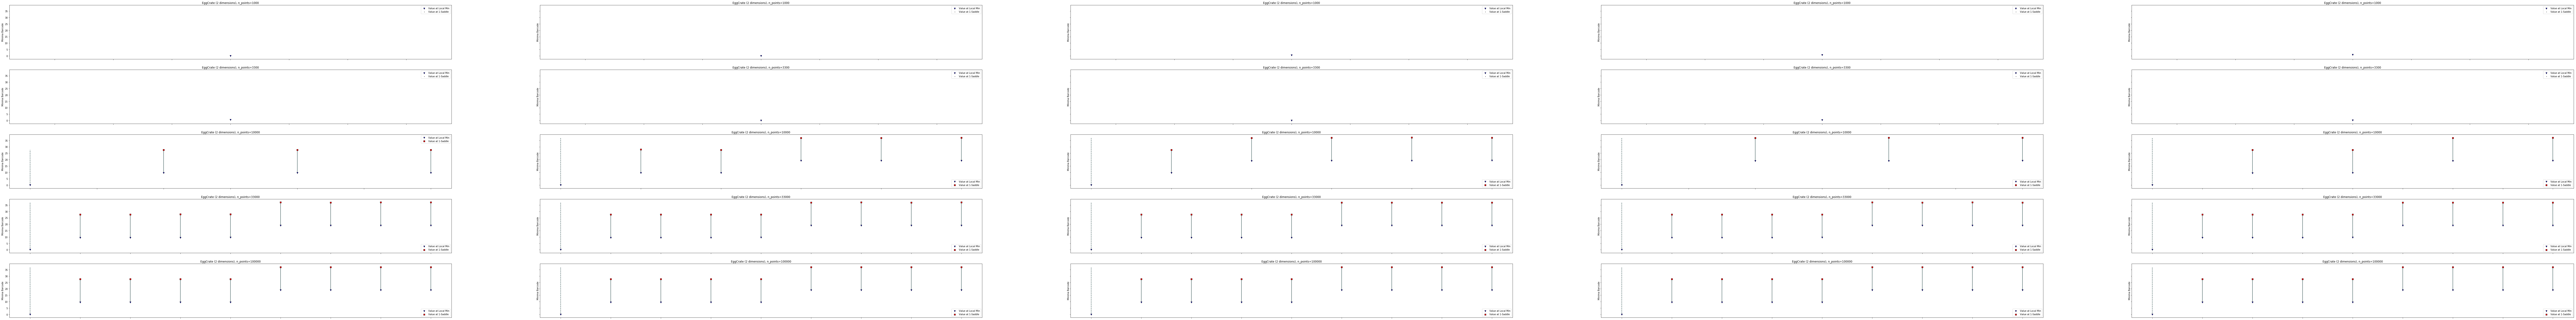

In [187]:
fig, axes = plt.subplots(len(Points), min(Repeats, 5), figsize=(5 * Repeats, 5 * len(Points)), sharey=True)
for points in range(len(Points)):
    for repeat in range(min(Repeats, 5)):
        plot_barcodes(
            results[points][repeat],
            ax=axes[points, repeat],
            min_cluster_size=300,
            title = f'{f}, n_points={Points[points]}'
        )

In [193]:
bottleneck = []
for points in tqdm(range(len(Points))):
    bottleneck.append([])
    for r in range(Repeats // 2):
        bottleneck[-1].append(gudhi.bottleneck_distance(
            results[points][r][['birth', 'death']].values,
            results[points][r + Repeats // 2][['birth', 'death']].values
        ))

In [207]:
dist = np.array(bottleneck)
dist[np.isinf(dist)] = np.nan

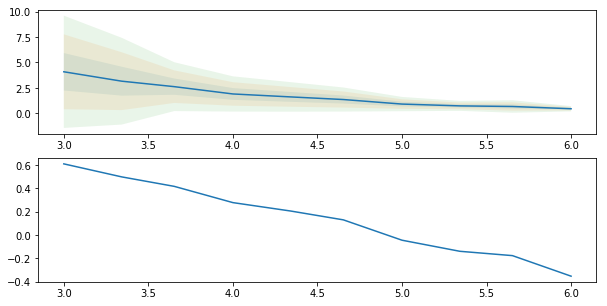

In [208]:
mean = np.nanmean(dist, axis=1)
std = np.nanstd(dist, axis=1)

fig, axes = plt.subplots(2, 1, figsize=(10, 5))
axes[0].plot(np.log10(Points), mean)
axes[0].fill_between(np.log10(Points), mean-1*std, mean+1*std, alpha=0.1)
axes[0].fill_between(np.log10(Points), mean-2*std, mean+2*std, alpha=0.1)
axes[0].fill_between(np.log10(Points), mean-3*std, mean+3*std, alpha=0.1)

axes[1].plot(np.log10(Points), np.log10(mean))

In [150]:
for n in range(len(ns_points)):
    dist = np.zeros((n_tests, n_tests), dtype=float)
    for i in range(n_tests):
        for j in range(i+1, n_tests):
            dist[i, j] = gudhi.bottleneck_distance(
                results[i][n][['birth', 'death']].values,
                results[j][n][['birth', 'death']].values
            )
            dist[j, i] = dist[i, j]
    print(dist.mean())

IndexError: list index out of range

In [135]:
dist.round(1)

array([[0. , 0.5, 0.5, 0.6, 0.5],
       [0.5, 0. , 0.6, 0.6, 0.5],
       [0.5, 0.6, 0. , 0.6, 0.5],
       [0.6, 0.6, 0.6, 0. , 0.5],
       [0.5, 0.5, 0.5, 0.5, 0. ]])